In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.keras._impl.keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import operator
from functools import reduce
from numpy import concatenate
import datetime as dt
import matplotlib.dates as mdates


In [2]:
dataset = pd.read_csv('/home/yaoling/Desktop/hangyan/income_PCA.csv', index_col='stat_date', parse_dates=['stat_date'])
dataset.head(3)

,Unnamed: 0,origin_total,total,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,...,Comp.9,Comp.10,Comp.11,Comp.12,Comp.13,Comp.14,Comp.15,Comp.16,Comp.17,Comp.18
stat_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,1.054359e+09,1.060150e+09,-3.722967,3.995390,-1.427039,-0.342712,0.250247,1.122027,0.187155,...,-0.013872,2.537875,-0.090666,-0.115397,-0.085228,0.078117,0.238693,0.359661,-0.213082,-0.017273
2016-01-02,2,1.066313e+09,1.070989e+09,-3.977367,3.852914,-1.388795,-0.385318,0.282414,1.105422,0.255038,...,-0.039693,2.252362,0.018632,-0.507548,-0.359579,0.164461,0.175537,0.172459,-0.205090,-0.049985
2016-01-03,3,1.092257e+09,1.091527e+09,-3.834691,2.950487,-2.036668,-0.270303,0.362256,1.271677,-0.045781,...,0.242025,1.494543,0.392993,-0.250873,0.524982,0.683681,0.021026,0.251070,-0.336074,0.098757


In [3]:
total= dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(7)
train_dataset_all = dataset.drop((missing_data[missing_data['Total'] > 400]).index,1)


In [4]:
train_dataset_show = train_dataset_all.iloc[:,2:3]


No handles with labels found to put in legend.


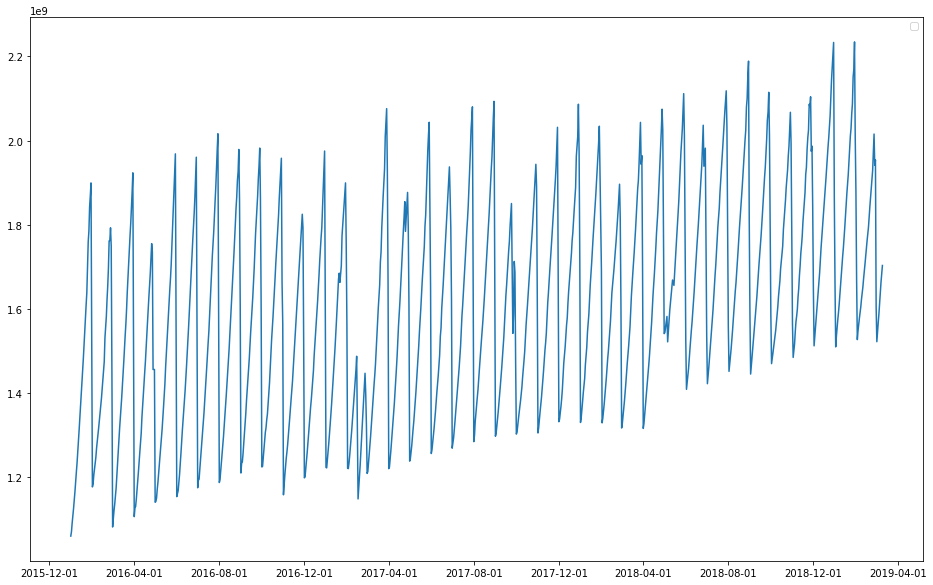

In [45]:
# date = train_dataset.iloc[:, 0:1]
# date = date.values
# ys = range(len(date))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())


date = train_dataset_all.index.values
dates = []

for i in range(len(date)):
    dates.append(str(int(date[i])))
    
# x = [dt.datetime.strptime(d,'%Y%m%d').date() for d in dates]
# y = range(len(x)) # many thanks to Kyss Tao for setting me straight here

plt.figure(figsize=(16,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(train_dataset_show)
plt.legend()
plt.show()

In [6]:
train_dataset = train_dataset_all.iloc[:,2:16]


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(train_dataset)


In [8]:
# 创建Ｘ_train, Y_train, 70%为训练集
def create_train_dataset(dataset, steps):
    X_train, Y_train = [], []
    for i in range(steps, len(dataset)):
        X_train.append(training_set_scaled[i-steps])
        Y_train.append(training_set_scaled[i, 0])
    return np.array(X_train), np.array(Y_train)

In [9]:
# 创建Ｘ_test, Y_test
split_rate = 0.7
k = int(len(train_dataset)*split_rate)
def create_test_dataset(dataset, steps):
    X_test, Y_test = [], []
    for i in range(steps, len(dataset)):
        X_test.append(training_set_scaled[i-steps+k])
        Y_test.append(training_set_scaled[i+k, 0])
    return np.array(X_test), np.array(Y_test)


In [10]:
train_size = int(len(train_dataset) * split_rate)
test_size = len(train_dataset) - train_size
train, test = train_dataset[0:train_size], train_dataset[train_size:len(train_dataset)]


In [11]:
# X为当前日期真实值，steps指定预测３天后的数据，　Ｙ当前日期三天后的真实值
steps = 3
X_train, Y_train = create_train_dataset(train, steps)
X_test, Y_test = create_test_dataset(test, steps)


In [12]:
# reshape（samples，input_dim，timesteps）的3D张量
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
X_train.shape

(812, 14, 1)

In [14]:
# 
regressor = tf.keras.models.Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))#一个特征和一个时间步长
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='adam')

regressor.fit(X_train, Y_train, epochs=80, batch_size = 2)


Epoch 1/80
812/812 [==============================] - 9s 11ms/step - loss: 0.0463
Epoch 2/80
812/812 [==============================] - 7s 9ms/step - loss: 0.0417
Epoch 3/80
812/812 [==============================] - 9s 11ms/step - loss: 0.0396
Epoch 4/80
812/812 [==============================] - 9s 11ms/step - loss: 0.0380
Epoch 5/80
812/812 [==============================] - 7s 9ms/step - loss: 0.0379
Epoch 6/80
812/812 [==============================] - 7s 9ms/step - loss: 0.0363
Epoch 7/80
812/812 [==============================] - 7s 9ms/step - loss: 0.0358
Epoch 8/80
812/812 [==============================] - 8s 10ms/step - loss: 0.0362
Epoch 9/80
812/812 [==============================] - 9s 11ms/step - loss: 0.0350
Epoch 10/80
812/812 [==============================] - 8s 9ms/step - loss: 0.0345
Epoch 11/80
812/812 [==============================] - 8s 9ms/step - loss: 0.0344
Epoch 12/80
812/812 [==============================] - 8s 9ms/step - loss: 0.0334
Epoch 13/80
812/812 

In [15]:
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)
trainPredict.shape, testPredict.shape

((812, 1), (347, 1))

In [16]:
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([Y_train])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([Y_test])
X_test.shape

(347, 14, 1)

In [17]:
# invert scaling for forecast
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
testPredict = concatenate((testPredict, X_test[:,1:]), axis=1)
testPredict = scaler.inverse_transform(testPredict)
testPredict = testPredict[:,0]

In [18]:
# invert scaling for actual
Y_test = Y_test.reshape((len(Y_test), 1))
testY = concatenate((Y_test, X_test[:, 1:]), axis=1)
testY = scaler.inverse_transform(testY)
testY = testY[:, 0]

In [19]:
# invert scaling for forecast
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
trainPredict = concatenate((trainPredict, X_train[:,1:]), axis=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = trainPredict[:,0]

In [20]:
# invert scaling for actual
Y_train = Y_train.reshape((len(Y_train), 1))
trainY = concatenate((Y_train, X_train[:, 1:]), axis=1)
trainY = scaler.inverse_transform(trainY)
trainY = trainY[:, 0]

In [21]:
testPredict[100:110], testY[100:110]

(array([1.54846608e+09, 1.56193434e+09, 1.58237056e+09, 1.59470027e+09,
        1.60672885e+09, 1.61729131e+09, 1.62990528e+09, 1.64940353e+09,
        1.66766309e+09, 1.68775925e+09]),
 array([1.52785245e+09, 1.54856320e+09, 1.57092981e+09, 1.59659050e+09,
        1.62574544e+09, 1.65258419e+09, 1.68047123e+09, 1.70426698e+09,
        1.73566872e+09, 1.76830811e+09]))

In [53]:
import math
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 151642787.03 RMSE
Test Score: 242271077.06 RMSE


In [54]:
trainPredict.shape, testPredict.shape

((812,), (347,))

In [55]:
train_dataset['predict'] = 0
type(trainPredict), trainPredict.shape

(numpy.ndarray, (812,))

In [56]:
train_dataset['predict'][3:815] = trainPredict
train_dataset['predict'][815:-3] = testPredict


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


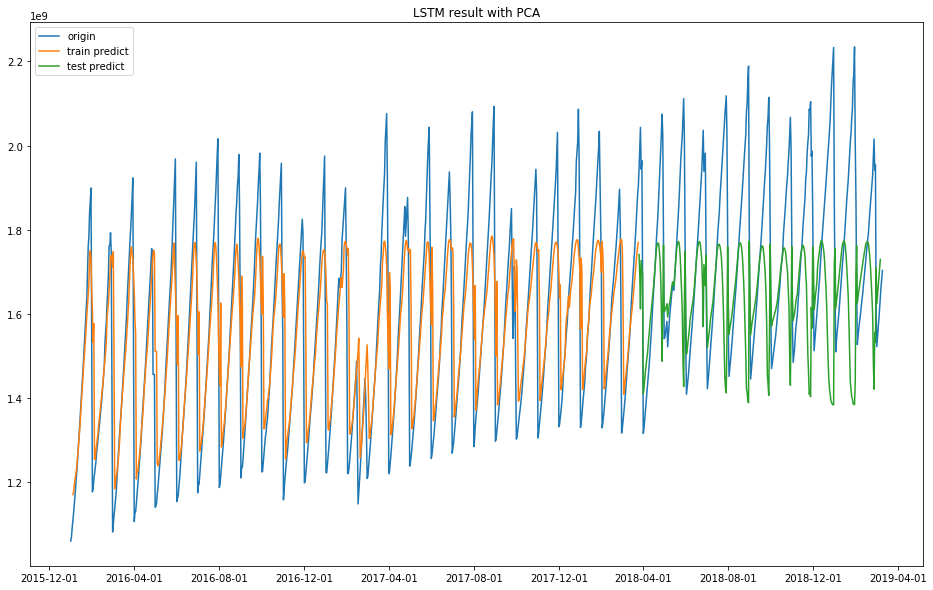

In [58]:
trainPredictPlot = np.empty_like(train_dataset)
trainPredictPlot[:, :] = np.nan
# trainPredictPlot[steps:len(trainPredict)+steps, :] = trainPredict
trainPredictPlot[steps:len(trainPredict)+steps,0] = trainPredict

testPredictPlot = np.empty_like(train_dataset)
testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(steps*2):len(train_dataset),:] = testPredict
testPredictPlot[len(trainPredict)+(steps*2):len(train_dataset),0] = testPredict

plt.figure(figsize=(16,10))
plt.title('LSTM result with PCA')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(train_dataset.iloc[:,0], label = 'origin')
plt.plot(train_dataset.iloc[3:815,14], label = 'train predict')
plt.plot(train_dataset.iloc[815:-3,14], label = 'test predict')

plt.legend()
plt.show()

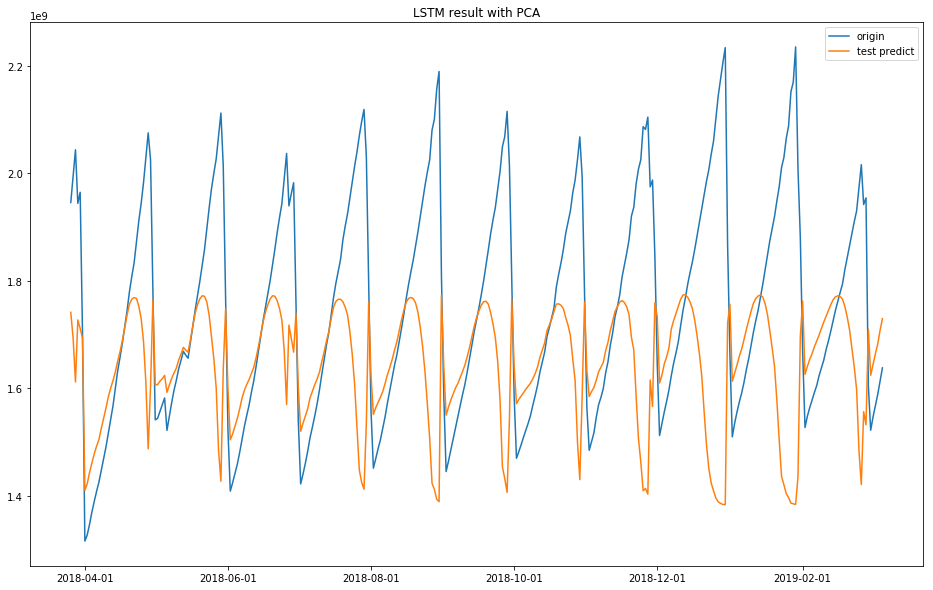

In [60]:
testPredictPlot = np.empty_like(train_dataset.iloc[len(trainPredict)+(steps*2):len(train_dataset),14])
testPredictPlot = np.nan

plt.figure(figsize=(16,10))
#plt.plot(train_dataset[len(trainPredict)+(steps*2):len(train_dataset),:], label = 'origin')
# plt.plot(train_dataset.iloc[len(trainPredict)+(steps*2):len(train_dataset),14], label = 'origin')
plt.title('LSTM result with PCA')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(train_dataset.iloc[815:-3,0], label = 'origin')
plt.plot(train_dataset.iloc[815:-3,14], label = 'test predict')

plt.legend()
plt.show()

In [28]:
dataset['evaluation'] = 0
dataset.head(3)

,Unnamed: 0,origin_total,total,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,...,Comp.10,Comp.11,Comp.12,Comp.13,Comp.14,Comp.15,Comp.16,Comp.17,Comp.18,evaluation
stat_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,1.054359e+09,1.060150e+09,-3.722967,3.995390,-1.427039,-0.342712,0.250247,1.122027,0.187155,...,2.537875,-0.090666,-0.115397,-0.085228,0.078117,0.238693,0.359661,-0.213082,-0.017273,0
2016-01-02,2,1.066313e+09,1.070989e+09,-3.977367,3.852914,-1.388795,-0.385318,0.282414,1.105422,0.255038,...,2.252362,0.018632,-0.507548,-0.359579,0.164461,0.175537,0.172459,-0.205090,-0.049985,0
2016-01-03,3,1.092257e+09,1.091527e+09,-3.834691,2.950487,-2.036668,-0.270303,0.362256,1.271677,-0.045781,...,1.494543,0.392993,-0.250873,0.524982,0.683681,0.021026,0.251070,-0.336074,0.098757,0


In [29]:
trainPredict_flatten = trainPredict.flatten()
testPredict_flatten = testPredict.flatten()

In [30]:
trainY.shape

(812,)

In [31]:
eva_train = []
sum_train = 0
len_train = 0
for i in range(len(trainPredict)):
#     evaluation_train = abs((trainPredict[i]/trainY[0][i])-1)
    evaluation_train = abs((trainPredict[i]/trainY[i])-1)
    eva_train.append(evaluation_train)
    sum_train += evaluation_train
    len_train += 1
print('result: ' + str(sum_train / len_train))

result: 0.06319821596932818


In [32]:
eva_test = []
sum_test = 0
len_test = 0
for i in range(len(testPredict)):
#     evaluation_test = abs((testPredict[i]/testY[0][i])-1)
    evaluation_test = abs((testPredict[i]/testY[i])-1)
    eva_test.append(evaluation_test)
    sum_test += evaluation_test
    len_test += 1
print('result: ' + str(sum_test / len_test))

result: 0.08571857618537831


In [33]:
submission_time = pd.DataFrame({
    'time': dataset.stat_date
})

submission_train = pd.DataFrame({
    'train_origin': reduce(operator.add, trainY),
    'train_Predict': trainPredict_flatten,
#     'train_evaluation': eva_train
})

submission_test = pd.DataFrame({
    'test_origin': reduce(operator.add, testY),
    'test_predict': testPredict_flatten,
#     'test_evaluation': eva_test
})


result = pd.concat([submission_train, submission_test], axis=1)
result.to_csv('/home/yaoling/Desktop/result_multi.csv', index=True)

AttributeError: 'DataFrame' object has no attribute 'stat_date'